In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pylops
from pylops.utils.wavelets import ricker

plt.style.use('default')
np.random.seed(0)

/home/wwd/miniconda3/envs/pytorch1_13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
par = {"ox": 0, "dx": 1, "nx": 101, "ot": 0, "dt": 0.004, "nt": 500, "f0": 30}

# linear events
v = 1500  # m/s
t0 = [0.5, 0.8, 1.3]  # s
theta = [0, 0, 0]
amp = [1.0, 0.8, 0.5]

# parabolic event
tp0 = [1, 1.5]  # s
px = [0, 0]  # s/m
pxx = [5e-5, 3e-5]  # s²/m²
ampp = [0.2, 0.4]

# create axis
taxis, taxis2, xaxis, yaxis = pylops.utils.seismicevents.makeaxis(par)

# create wavelet
wav = ricker(taxis[:41], f0=par["f0"])[0]

# generate model
y = (
    pylops.utils.seismicevents.linear2d(xaxis, taxis, v, t0, theta, amp, wav)[1]
    + pylops.utils.seismicevents.parabolic2d(xaxis, taxis, tp0, px, pxx, ampp, wav)[1]
)

(np.float64(0.0), np.float64(100.0), np.float64(1.996), np.float64(0.0))

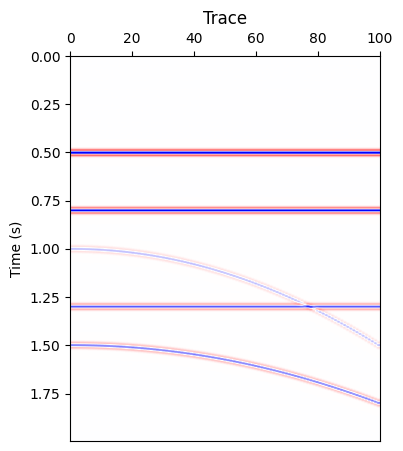

In [3]:
pclip = 0.7
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(4, 5))
axs.imshow(
    y.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(y).max(),
    vmax=pclip * np.abs(y).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs.set(ylabel="Time (s)", title="Trace")
axs.xaxis.set_ticks_position('top')
axs.xaxis.set_label_position('top')
axs.axis("tight")

In [4]:
nfft = int(2 ** np.ceil(np.log2(par["nt"])))
print(nfft)
npx, pxmax = 4 * par["nx"], 5e-4
px = np.linspace(-pxmax, pxmax, npx)

R2Op = pylops.signalprocessing.FourierRadon2D(
    taxis, xaxis, px, nfft, kind="parabolic", engine="numpy", dtype="float64"
)

print(R2Op.shape)
print(R2Op.H.shape)
print(y.shape)

512
(50500, 202000)
(202000, 50500)
(101, 500)


In [5]:
dL = R2Op.H * y

In [6]:
dadj = R2Op * dL

In [7]:
xinv_P, niter_P, cost_P = pylops.optimization.sparsity.fista(
    R2Op, y.ravel(), niter=10, eps=1e1
)
xinv_P = xinv_P.reshape(R2Op.dims)

xfilt_P = np.zeros_like(dL)
xfilt_P[npx // 2 - 3 : npx // 2 + 4] = dL[npx // 2 - 3 : npx // 2 + 4]

yfilt_P = R2Op * xfilt_P

xinvfilt_P = np.zeros_like(xinv_P)
xinvfilt_P[npx // 2 - 3 : npx // 2 + 4] = xinv_P[npx // 2 - 3 : npx // 2 + 4]

yinvfilt_P = R2Op * xinvfilt_P

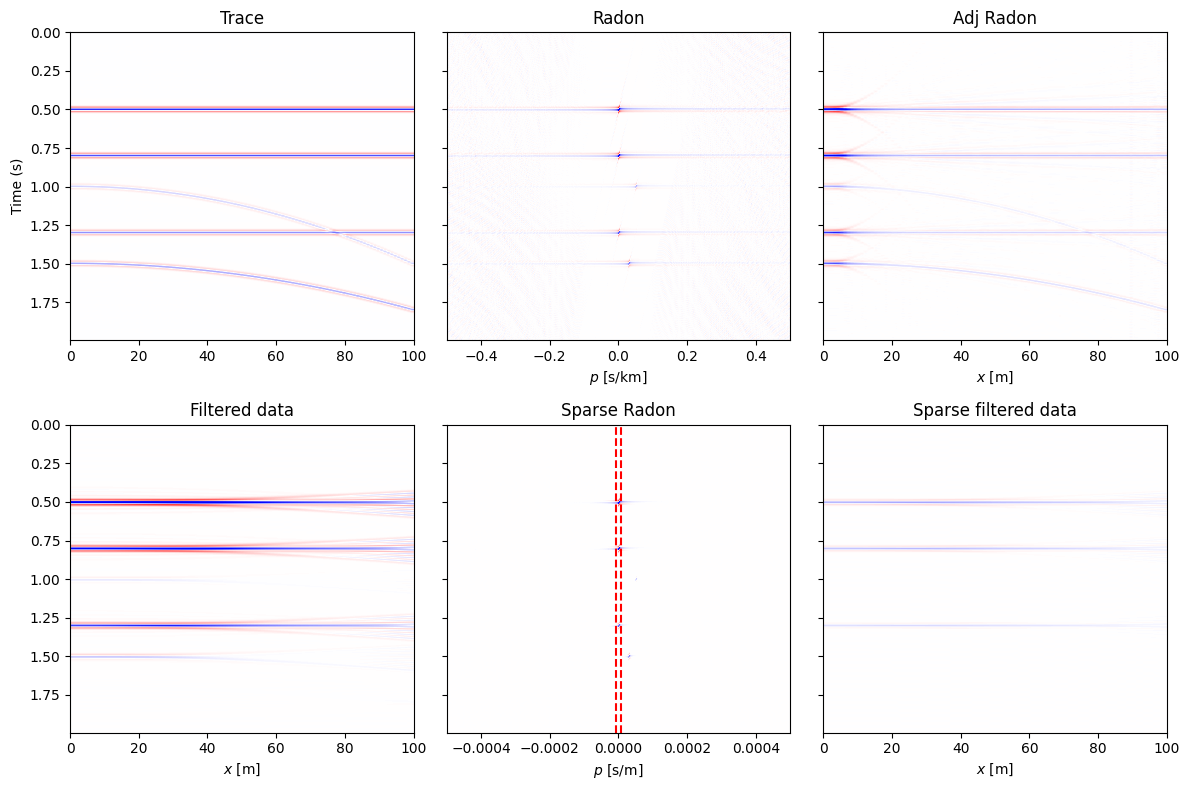

In [8]:
pclip = 0.5

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

axs[0, 0].imshow(y.T, vmin=-1, vmax=1, cmap="bwr_r", extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0, 0].set(ylabel=r"Time (s)", title="Trace")
axs[0, 0].axis("tight")

axs[0, 1].imshow(
    dL.T,
    cmap="bwr_r",
    vmin=-dL.max() * pclip,
    vmax=dL.max() * pclip,
    extent=(1e3 * px[0], 1e3 * px[-1], taxis[-1], taxis[0]),
)
axs[0, 1].set(xlabel=r"$p$ [s/km]", title="Radon")
axs[0, 1].axis("tight")

axs[0, 2].imshow(
    dadj.T,
    cmap="bwr_r",
    vmin=-dadj.max() * pclip,
    vmax=dadj.max() * pclip,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[0, 2].set(xlabel=r"$x$ [m]", title="Adj Radon")
axs[0, 2].axis("tight")

# filter
axs[1, 0].imshow(
    yfilt_P.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(yfilt_P).max(),
    vmax=pclip * np.abs(yfilt_P).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[1, 0].set(xlabel="$x$ [m]", title="Filtered data")
axs[1, 0].axis("tight")

# sparse radon
axs[1, 1].imshow(
    xinv_P.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(xinv_P).max(),
    vmax=pclip * np.abs(xinv_P).max(),
    extent=(px[0], px[-1], taxis[-1], taxis[0]),
)
axs[1, 1].axvline(px[npx // 2 - 3], color="r", linestyle="--")
axs[1, 1].axvline(px[npx // 2 + 3], color="r", linestyle="--")
axs[1, 1].set(xlabel="$p$ [s/m]", title="Sparse Radon")
axs[1, 1].axis("tight")

# filter sparse radon
axs[1, 2].imshow(
    yinvfilt_P.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(y).max() * pclip,
    vmax=pclip * np.abs(y).max() * pclip,
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[1, 2].set(xlabel="$x$ [m]", title="Sparse filtered data")
axs[1, 2].axis("tight")

plt.tight_layout()

In [9]:
N = 2

flow = 2
fhigh = 90
mu = 0.1

qmin = -1
qmax = 1

nfft_my = 2 * (2**np.ceil(np.log2(par["nt"])).astype(int))
ilow = int(np.floor(flow * par["dt"] * nfft_my)) + 1
ilow = max(ilow, 0)
ihigh = int(np.floor(fhigh * par["dt"] * nfft_my)) + 1
ihigh = min(ihigh, nfft_my // 2)
nq = ihigh - ilow + 1

dq = (qmax - qmin) / (nq - 1)
q = qmin + dq * np.arange(nq)

In [ ]:
from inverse_radon_freq import inverse_radon_freq

m = inverse_radon_freq(y.T, par["dt"], xaxis, q, N, flow, fhigh, mu, 'ls')
m.shape

(500, 361)

In [11]:
from inverse_radon_freq import inverse_radon_freq_lambda

m_lamb, M_lamb = inverse_radon_freq_lambda(y.T, par["dt"], xaxis, qmin, qmax, N, flow, fhigh, mu, 'ls')
print(m_lamb.shape)
print(M_lamb.shape)

(500, 361)
(1024, 361)


(np.float64(-0.09), np.float64(0.09), np.float64(90.0), np.float64(0.0))

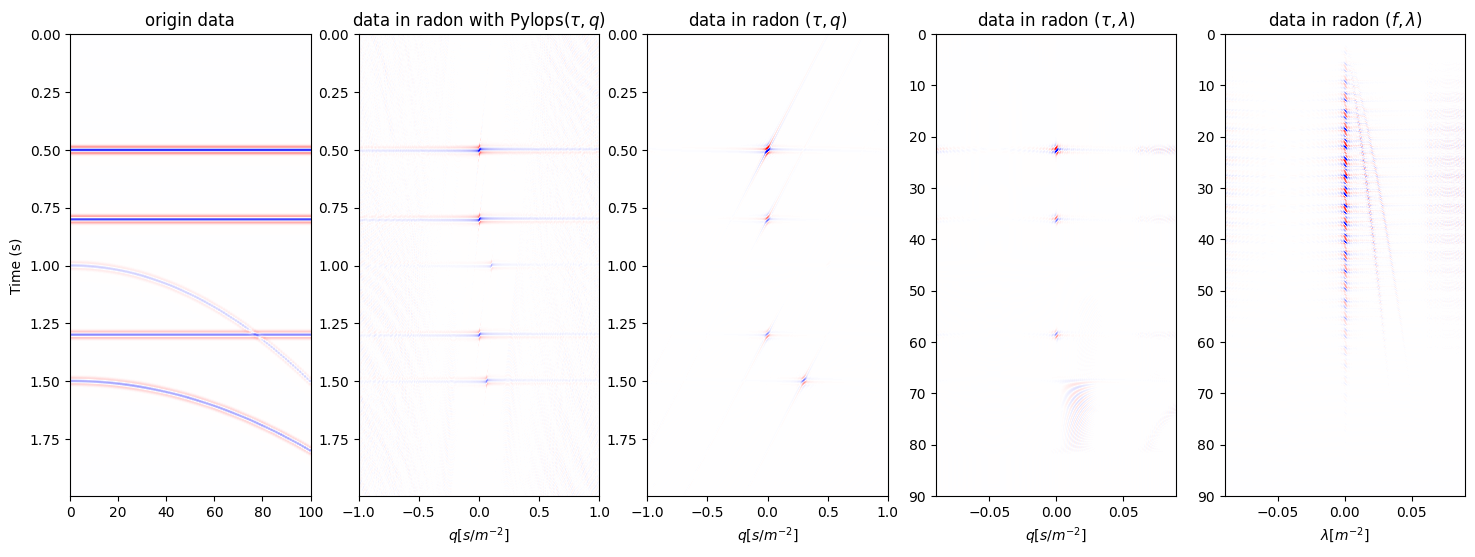

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(18, 6))

axs[0].imshow(y.T, vmin=-1, vmax=1, cmap="bwr_r", extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set(ylabel=r"Time (s)", title="origin data")
axs[0].axis("tight")

axs[1].imshow(
    dL.T,
    cmap="bwr_r",
    vmin=-dL.max() * pclip,
    vmax=dL.max() * pclip,
    extent=(qmin, qmax, taxis[-1], taxis[0]),
)
axs[1].set(xlabel="$q [s/m^{-2}]$", title="data in radon with Pylops($\\tau, q$)")
axs[1].axis("tight")

axs[2].imshow(
    m,
    cmap="bwr_r",
    vmin=-m.max() * pclip,
    vmax=m.max() * pclip,
    extent=(qmin, qmax, taxis[-1], taxis[0]),
)
axs[2].set(xlabel="$q [s/m^{-2}]$", title="data in radon ($\\tau, q$)")
axs[2].axis("tight")

# filter data
axs[3].imshow(
    m_lamb,
    cmap="bwr_r",
    vmin=-pclip * np.abs(m_lamb).max(),
    vmax=pclip * np.abs(m_lamb).max(),
    extent=(qmin * fhigh * 1e-3, qmax * fhigh * 1e-3, fhigh, 0),
)
axs[3].set(xlabel="$q [s/m^{-2}]$", title="data in radon ($\\tau, \lambda$)")
axs[3].axis("tight")

# sparse radon
axs[4].imshow(
    M_lamb[:400].real,
    cmap="bwr_r",
    vmin=-pclip * np.abs(M_lamb).max(),
    vmax=pclip * np.abs(M_lamb).max(),
    extent=(qmin * fhigh * 1e-3, qmax * fhigh * 1e-3, fhigh, 0),
)

axs[4].set(xlabel="$\lambda [m^{-2}]$", title="data in radon ($f, \lambda$)")
axs[4].axis("tight")

In [13]:
def radon_filter(data, delta):
    output = np.zeros_like(data)
    _, n = data.shape
    
    mid = n // 2
    output[:, mid - delta: mid + delta + 1] = data[:, mid - delta: mid + delta + 1]
    return output

In [26]:
m_filt = radon_filter(m, 2)

m_lamb_filt = radon_filter(m_lamb, 2)

M_lamb_filt = radon_filter(M_lamb, 10)

(np.float64(-0.09), np.float64(0.09), np.float64(90.0), np.float64(0.0))

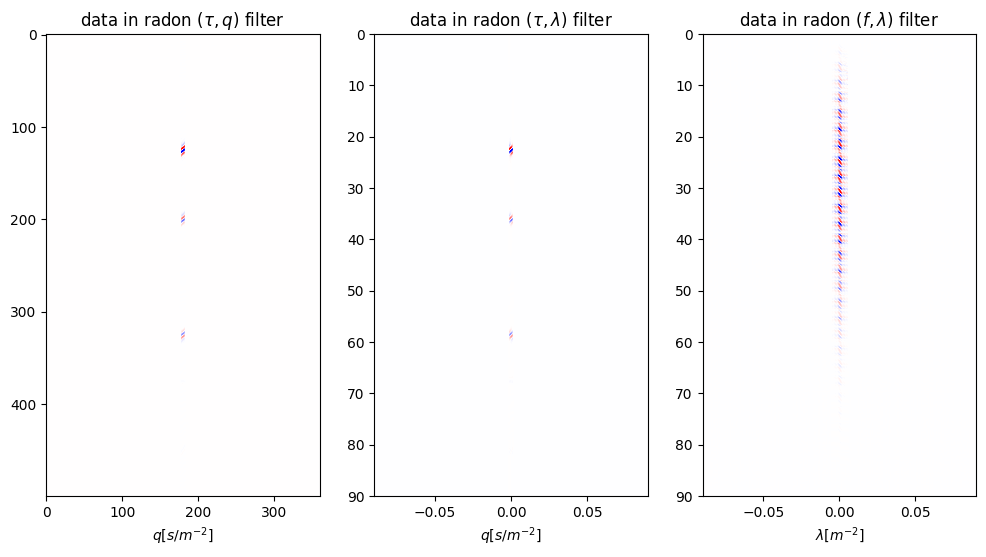

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(
    m_filt,
    cmap="bwr_r",
    vmin=-m_filt.max() * pclip,
    vmax=m_filt.max() * pclip,
)
axs[0].set(xlabel="$q [s/m^{-2}]$", title="data in radon ($\\tau, q$) filter")
axs[0].axis("tight")

axs[1].imshow(
    m_lamb_filt,
    cmap="bwr_r",
    vmin=-m_lamb_filt.max() * pclip,
    vmax=m_lamb_filt.max() * pclip,
    extent=(qmin * fhigh * 1e-3, qmax * fhigh * 1e-3, fhigh, 0),
)
axs[1].set(xlabel="$q [s/m^{-2}]$", title="data in radon ($\\tau, \lambda$) filter")
axs[1].axis("tight")

axs[2].imshow(
    M_lamb_filt[:400].real,
    cmap="bwr_r",
    vmin=-pclip * np.abs(M_lamb_filt).max(),
    vmax=pclip * np.abs(M_lamb_filt).max(),
    extent=(qmin * fhigh * 1e-3, qmax * fhigh * 1e-3, fhigh, 0),
)
axs[2].set(xlabel="$\lambda [m^{-2}]$", title="data in radon ($f, \lambda$) filter")
axs[2].axis("tight")

In [28]:
from forward_radon_freq import forward_radon_freq

m_inverse = forward_radon_freq(m_filt, par["dt"], xaxis, q, N, flow, fhigh)

m_lamb_inverse = forward_radon_freq(m_lamb_filt, par["dt"], xaxis, q, N, flow, fhigh)

M_lamb_inverse = forward_radon_freq(M_lamb_filt, par["dt"], xaxis, q, N, flow, fhigh)
print(M_lamb_inverse.shape)

(1024, 101)


(np.float64(0.0), np.float64(100.0), np.float64(1.996), np.float64(0.0))

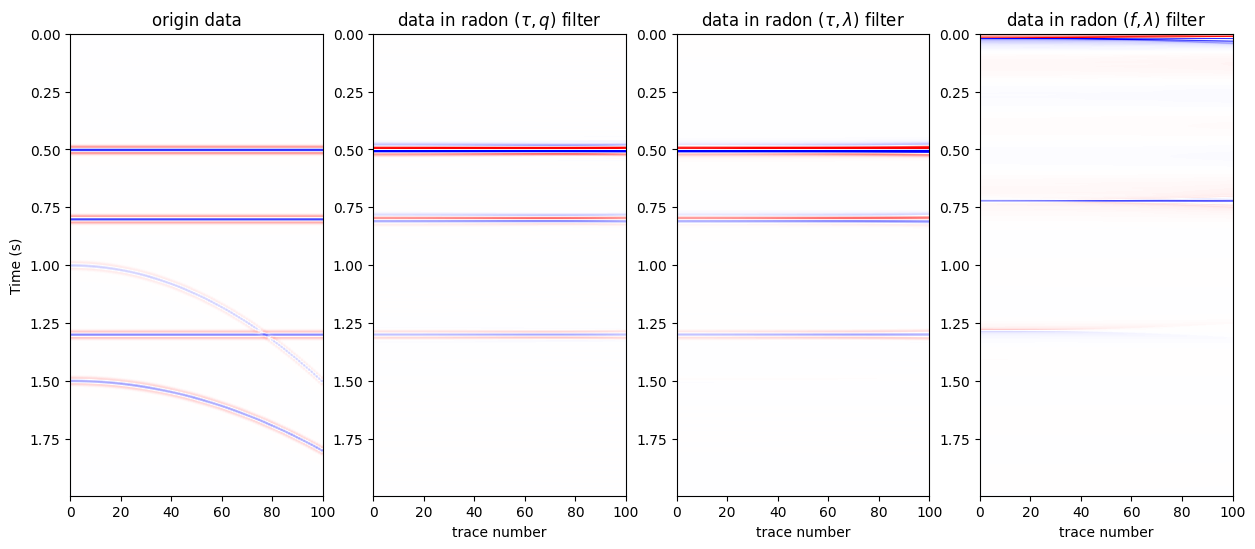

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

axs[0].imshow(y.T, vmin=-1, vmax=1, cmap="bwr_r", extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set(ylabel=r"Time (s)", title="origin data")
axs[0].axis("tight")

axs[1].imshow(
    m_inverse,
    cmap="bwr_r",
    vmin=-pclip * np.abs(m_inverse).max(),
    vmax=pclip * np.abs(m_inverse).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[1].set(xlabel="trace number", title="data in radon ($\\tau, q$) filter")
axs[1].axis("tight")

axs[2].imshow(
    m_lamb_inverse,
    cmap="bwr_r",
    vmin=-pclip * np.abs(m_lamb_inverse).max(),
    vmax=pclip * np.abs(m_lamb_inverse).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[2].set(xlabel="trace number", title="data in radon ($\\tau, \lambda$) filter")
axs[2].axis("tight")

axs[3].imshow(
    M_lamb_inverse,
    cmap="bwr_r",
    vmin=-pclip * np.abs(M_lamb_inverse).max(),
    vmax=pclip * np.abs(M_lamb_inverse).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs[3].set(xlabel="trace number", title="data in radon ($f, \lambda$) filter")
axs[3].axis("tight")